In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import pprint
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import json
import models
from sweeps.sweep_utils import *

In [2]:
hbm_capacity_list, hbm_bandwidth_list, params = sweep_bw_capacity() # sweep over a range of bandwidths and capacities
numx = len(hbm_capacity_list)
numy = len(hbm_bandwidth_list)
print('Total configs = ', numx * numy)
print('HBM capacity = ', hbm_capacity_list)
print('HBM BW = ', hbm_bandwidth_list)

Total configs =  896
HBM capacity =  [  80.          109.67741935  139.35483871  169.03225806  198.70967742
  228.38709677  258.06451613  287.74193548  317.41935484  347.09677419
  376.77419355  406.4516129   436.12903226  465.80645161  495.48387097
  525.16129032  554.83870968  584.51612903  614.19354839  643.87096774
  673.5483871   703.22580645  732.90322581  762.58064516  792.25806452
  821.93548387  851.61290323  881.29032258  910.96774194  940.64516129
  970.32258065 1000.        ]
HBM BW =  [  500.          1074.07407407  1648.14814815  2222.22222222
  2796.2962963   3370.37037037  3944.44444444  4518.51851852
  5092.59259259  5666.66666667  6240.74074074  6814.81481481
  7388.88888889  7962.96296296  8537.03703704  9111.11111111
  9685.18518519 10259.25925926 10833.33333333 11407.40740741
 11981.48148148 12555.55555556 13129.62962963 13703.7037037
 14277.77777778 14851.85185185 15425.92592593 16000.        ]


model is {'l': 2048, 'e': 25600, 'h': 160, 'depth': 128, 'f': 102400}
training on 488281250.0 samples


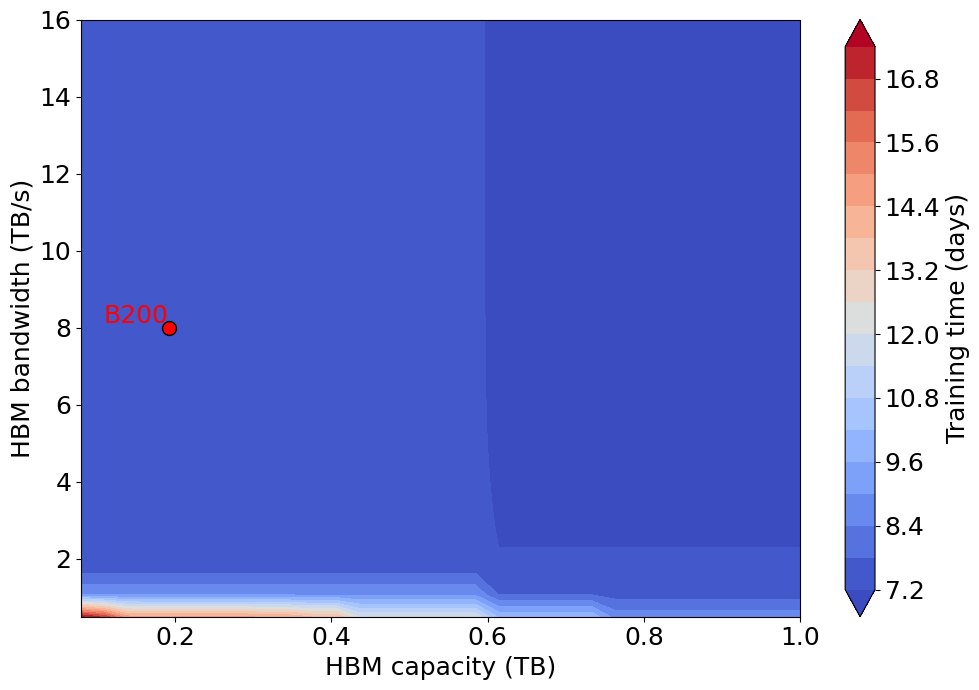

In [3]:
model_str = 'gpt3_1T'
model = models.models[model_str]
par_strat = '1d'
# set model hyperparams
l = model['l']
e = model['e']
f = 4 * e
model['f'] = f
h = model['h']
depth = model['depth']
print('model is {}'.format(model))

'''set some dataset size hyperparameters 
   if LLMs, it's number of tokens, else
   it's number of samples in ERA5.     '''

if model_str == 'gpt3_1T':
    total_tokens = 1 * 10**12
else:
    total_tokens = 300 * 10**9
    
num_samples = total_tokens / l
if 'vit_era5' in model_str:
    num_ep = 80
    num_samples = 350000 * num_ep
print('training on {} samples'.format(num_samples))
global_batch_size = 4096

I = np.linspace(0, numx-1, numx)
J = np.linspace(0, numy-1, numy)

C, B = np.meshgrid(hbm_capacity_list, hbm_bandwidth_list, indexing='ij')
T = []
check_at_gpu = 8192

for st, p in enumerate(params):
    sys_str = 'B200-{}'.format(str(st))
    
    x = np.load('../outputs/sweeps/sweep_bw_cap_{}_{}_{}.npy'.format(par_strat, model_str, sys_str), allow_pickle=True)
    nvc = 0
    for nvs, t_max, t_min, n_gpus, configs in x:
        if len(t_max) == 0 or (check_at_gpu not in n_gpus):
            T.append(np.nan)
            continue
        time = [(num_samples / tm) / (3600 * 24) for tm in t_max]
        idx = list(n_gpus).index(check_at_gpu)
        T.append(time[idx])        
        nvc += 1

T = np.array(T).reshape(B.shape)
fig, ax1 = plt.subplots(figsize=(10, 7), tight_layout=True)
contour = ax1.contourf(C/1E3, B/1E3, T, levels=20, cmap='coolwarm', extend='both')
cbar = plt.colorbar(contour, ax=ax1)
cbar.set_label('Training time (days)', fontsize=18)
cbar.ax.tick_params(labelsize=18) 
ax1.set_xlabel('HBM capacity (TB)', fontsize=18)
ax1.set_ylabel('HBM bandwidth (TB/s)', fontsize=18)
ax1.tick_params(axis='both', labelsize=18)
ax1.set_xlim(hbm_capacity_list[0]/1E3, hbm_capacity_list[-1]/1E3)
ax1.set_ylim(hbm_bandwidth_list[0]/1E3, hbm_bandwidth_list[-1]/1E3)
data_points = [(.192, 8.000)]

labels = ['B200']
colors = ['red']

for (x, y), label, color in zip(data_points, labels, colors):
    plt.scatter(x, y, color=color, s=100, edgecolor='black', zorder=5)
    plt.text(x, y, label, fontsize=18, ha='right', va='bottom', color=color, zorder=10)

plt.savefig('../outputs/bwcap_{}_{}.pdf'.format(par_strat, model_str), dpi=400)